In [19]:
!python -V

Python 3.12.9


In [20]:
import pandas as pd
import pickle
import seaborn as sns
import matplotlib.pyplot as plt

In [21]:
from sklearn.feature_extraction import DictVectorizer
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Lasso
from sklearn.linear_model import Ridge
from sklearn.metrics import mean_squared_error


In [22]:
import mlflow

mlflow.set_tracking_uri("sqlite:///mlflow.db")
mlflow.set_experiment("nyc-taxi-experiment")

<Experiment: artifact_location='/home/flavio/mlops-project/training/mlruns/1', creation_time=1744161078831, experiment_id='1', last_update_time=1744161078831, lifecycle_stage='active', name='nyc-taxi-experiment', tags={}>

In [23]:
df = pd.read_parquet("data/green_tripdata_2024-01.parquet")
df.lpep_dropoff_datetime = pd.to_datetime(df.lpep_dropoff_datetime)
df.lpep_pickup_datetime = pd.to_datetime(df.lpep_pickup_datetime)

df["duration"] = (df.lpep_dropoff_datetime - df.lpep_pickup_datetime).dt.total_seconds() / 60
# df.duration = df.duration.apply(lambda td: td.total_seconds() / 60)

df = df[(df.duration >= 1) & (df.duration <= 60)] 

categorical = ["PULocationID", "DOLocationID"]
numerical = ["passenger_count", "duration"]

df[categorical] = df[categorical].astype(str)


In [24]:
# Drop rows with missing values
df_clean = df.dropna(subset=categorical + numerical)
# Convert dataframe to dictionary format for vectorization
train_dicts = df_clean[categorical + numerical].to_dict(orient="records")

# One-hot encode categorical features
dv = DictVectorizer()
X_train = dv.fit_transform(train_dicts)

target = 'duration'
y_train = df_clean[target].values

# Train linear regression model
lr = LinearRegression()
lr.fit(X_train, y_train)

# Evaluate model performance
y_pred = lr.predict(X_train)
mean_squared_error(y_train, y_pred)

6.48611735383391e-10

/tmp/ipykernel_1557/1782652723.py:1: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(y_pred, label = 'prediction', color='red')
/tmp/ipykernel_1557/1782652723.py:2: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(y_train, label = 'actual')


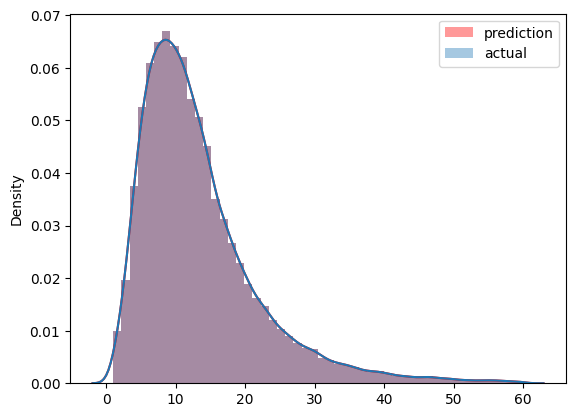

In [25]:
sns.distplot(y_pred, label = 'prediction', color='red')
sns.distplot(y_train, label = 'actual')
plt.legend()
plt.show()

In [26]:
with mlflow.start_run():
    mlflow.set_tag("developer", "asmunck")

    mlflow.log_param("train-data-path", "data/green_tripdata_2024-01.parquet")
    mlflow.log_param("valid-data-path", "data/green_tripdata_2024-02.parquet")

    alpha = 0.01
    mlflow.log_param("alpha", alpha)
    lr = Lasso(alpha)
    lr.fit(X_train, y_train)

    y_pred = lr.predict(X_train)
    mse = mean_squared_error(y_train, y_pred)
    mlflow.log_metric("mse", mse)
    mlflow.log_metric("rmse", mse ** 0.5)

In [27]:
import xgboost as xgb

from hyperopt import fmin, tpe, hp, STATUS_OK, Trials
from hyperopt.pyll import scope

In [ ]:
train = xgb.DMatrix(X_train, label=y_train)
valid = xgb.DMatrix(X_val, label=y_val)

In [ ]:
def objective(params):
    with mlflow.start_run():
        mlflow.set_tag("model", "xgboost")
        mlflow.log_params(params)
        booster = xgb.train(
            params=params,
            dtrain=train,
            num_boost_around=1000,
            evals=[(valid, "validation")],
            early_stopping_rounds=50
        )
        y_pred = booster.predict(valid)
        rmse = mean_squared_error(y_val, y_pred)
        mlflow.log_metric("rmse", rmse**2)
    
    return {'loss': rmse, 'status': STATUS_OK}

In [ ]:
search_space = {
    'max_depth': scope.int(hp.quniform('max_depth', 4, 100, 1)),
    'learning_rate': hp.loguniform('learning_rate', -3, 0),
    'reg_alpha': hp.loguniform('reg_alpha', -5, 1),
    'reg_lambda': hp.loguniform('reg_lambda', -6, 1),
    'min_child_weight': hp.loguniform('min_child_weight', -1, 3),
    'objective': 'reg:linear',
    'seed': 42
}

best_result = fmin(
    fn=objective,
    space=search_space,
    algo=tpe.suggest,
    max_evals=100,
    trials=Trials()
)